# Model training routines
We are using the wrappers created in the classes contained in this folder.

We are going to load the data. Images are grouped in sub-folders for each category

We will be using the class `TrainReader` that will load the labeled images and scale them to 128x128 pixels if they have different size.  `PrepareTrainingData` is the next class we will use to split the data for training and validation and provide a handy transformation implementation for any function we may pass to it.

## Metrics to use
We are going to use f1 score as the main metric. It provides a good overview of the model performance, with insights on precion and recall, being sensitive if any if both performs badly. 

## Load data

In [1]:
from arch_elements.etl.transform import PrepareTrainingData
from arch_elements.etl import TrainReader
import os
reader = TrainReader(os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)),"potantial_datasets","archElements_128"))
pixels = 128
x, y_labels = reader.load((pixels, pixels))

etl = PrepareTrainingData()
y = etl.encode(y_labels)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from arch_elements.utils import plot_samples

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

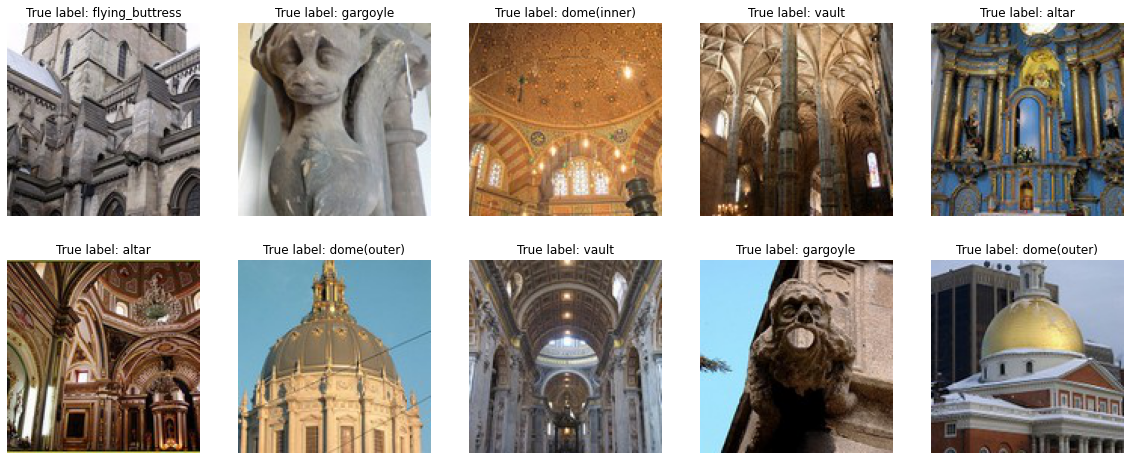

In [7]:
# Exploring the data
plot_samples(x, y, etl.encoder, 10)

<BarContainer object of 10 artists>

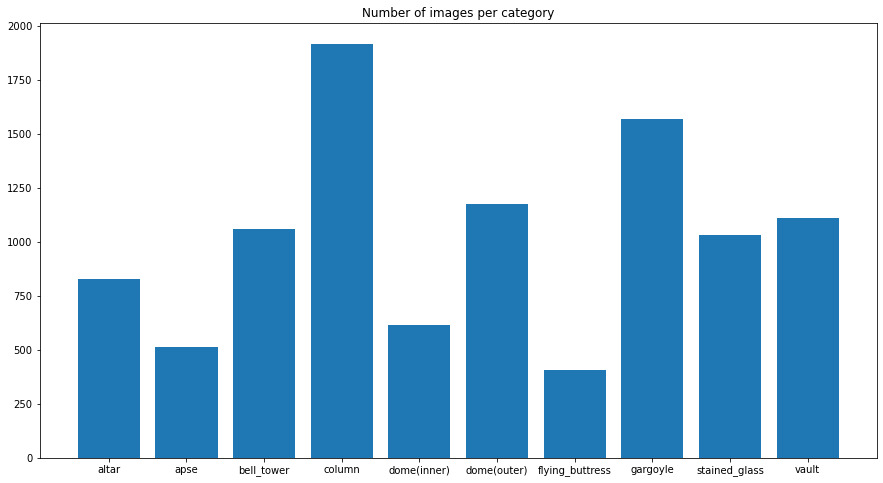

In [3]:
ls_tmp = y_labels.tolist()
ls = list(set(ls_tmp))
ls.sort()
freq = []
for c in ls:
    freq.append(ls_tmp.count(c))
_, ax = plt.subplots(figsize=(15, 8))
ax.set_title('Number of images per category')
plt.bar(ls, freq)

We can see that we don't have the same number of images for each category. This is not ideal, however, we will see if this affects the predictions or not. 

## Traditional approach
SVM classifiers using PCA to reduce dimensionality. First only applying a technical transformation to flatten the images. From a quick plot of the variance vs the number of components, we see that we need a lot of components, so let's use for now 100. They might be a lot for SVM and we may face the curse of dimensionality but with less the model might not have good results. 

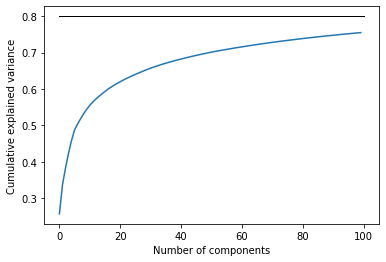

In [18]:
from sklearn.decomposition import PCA
x_pca_analysis = [ i.flatten() for i in x]
n_components = 100
pca = PCA(n_components=n_components)
pca_fit = pca.fit_transform(x_pca_analysis)
variances = pca.explained_variance_ratio_

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.plot(np.cumsum(variances))
plt.plot([0,n_components],[0.8,0.8],'k-',lw=1)
#plt.savefig('expained_variance.jpg')
#plt.show()


In [4]:
from arch_elements.model_train import SVMCTrainer

eval_metrics = {accuracy_score:{}, f1_score:{'average':'weighted'}}
flatten = lambda i: i.flatten()

etl.transform(x, y, extra_transformations=[flatten], 
              test_split=0.2, validation_split=0.001)
x_test, y_test = etl.get_test_data()
y_test = np.argmax(y_test, axis=1)

In [5]:
trainer = SVMCTrainer()
trainer.train(etl)

In [6]:
trainer.evaluate_metrics(x_test, y_test, metrics=eval_metrics)

{'accuracy_score': 0.20556640625, 'f1_score': 0.32383187739038727}

We see a pretty bad score, and changing the number of components of the PCA does not help.
Let's try to add gray scale transformation

In [7]:
from skimage.color import rgb2gray
etl.transform(x, y, extra_transformations=[rgb2gray, flatten], 
              test_split=0.2, validation_split=0.001)
x_test, y_test = etl.get_test_data()
y_test = np.argmax(y_test, axis=1)
trainer = SVMCTrainer()
trainer.train(etl)
trainer.evaluate_metrics(x_test, y_test, metrics=eval_metrics)

{'accuracy_score': 0.20556640625, 'f1_score': 0.32383187739038727}

This has not helped, and the metrics are bad. 

### Applying extra transformations
We are going to converi the images to gray and use a transformation called Histogram of oriented gradients (HOG) to reduce dimensionality and tru to obtain the main directions present on a region. 

This is a feature descriptor, used mainly in object detection. We will see that it detects general shapes and some patterns of the images.  

In [8]:
from skimage.color import rgb2gray
from skimage.feature import hog
def apply_hog(image:np.array) -> np.array:
  resulting_hog, _ = hog(
    image, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
  return resulting_hog
  

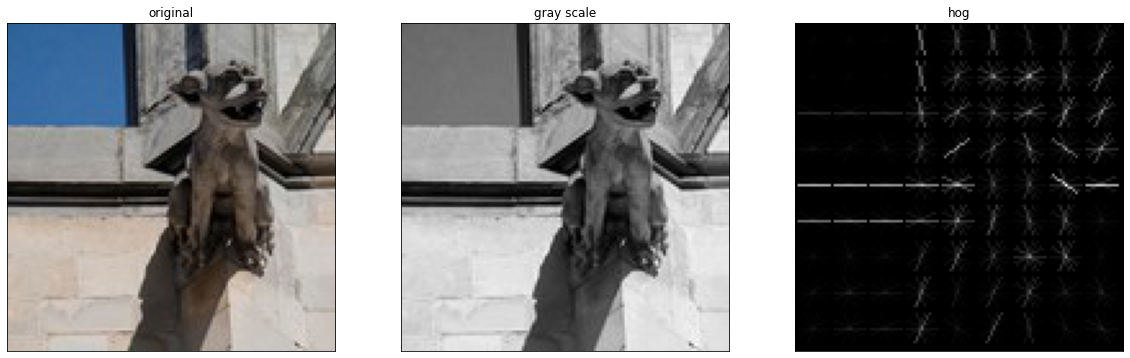

In [9]:
i = x[7634]
resulting_hog, hog_image = hog(
    rgb2gray(i), pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')

fig, ax = plt.subplots(1,3, figsize=(20, 8))
#fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) for a in ax]
 
ax[0].imshow(i.astype('uint8'))
ax[0].set_title('original')
ax[1].imshow(rgb2gray(i), cmap='gray')
ax[1].set_title('gray scale')
ax[2].imshow(hog_image, cmap='gray')
ax[2].set_title('hog')
plt.show()

We see that the resulting image has removed the background and we can detect two different patterns: the horizontal lines of the rood and an extra shape in the gargolye region. The transformation is more useful if there is a clear difference between the background and the object you want to detect, but as a first step it will do.

This is resource intensive and could eventually be paralelized using apache spark. For now though, it is fine for our number of datasets and processing power. 

In [10]:
from skimage.color import rgb2gray
etl.transform(x, y, extra_transformations=[rgb2gray, apply_hog], 
              test_split=0.2, validation_split=0.001)
x_test, y_test = etl.get_test_data()
y_test = np.argmax(y_test, axis=1)
trainer = SVMCTrainer()
trainer.train(etl)
trainer.evaluate_metrics(x_test, y_test, metrics=eval_metrics)

{'accuracy_score': 0.77978515625, 'f1_score': 0.783571153135153}

We can see that the metrics improved a lot. From 0.3 to 0.78 with this simple tranformation. 


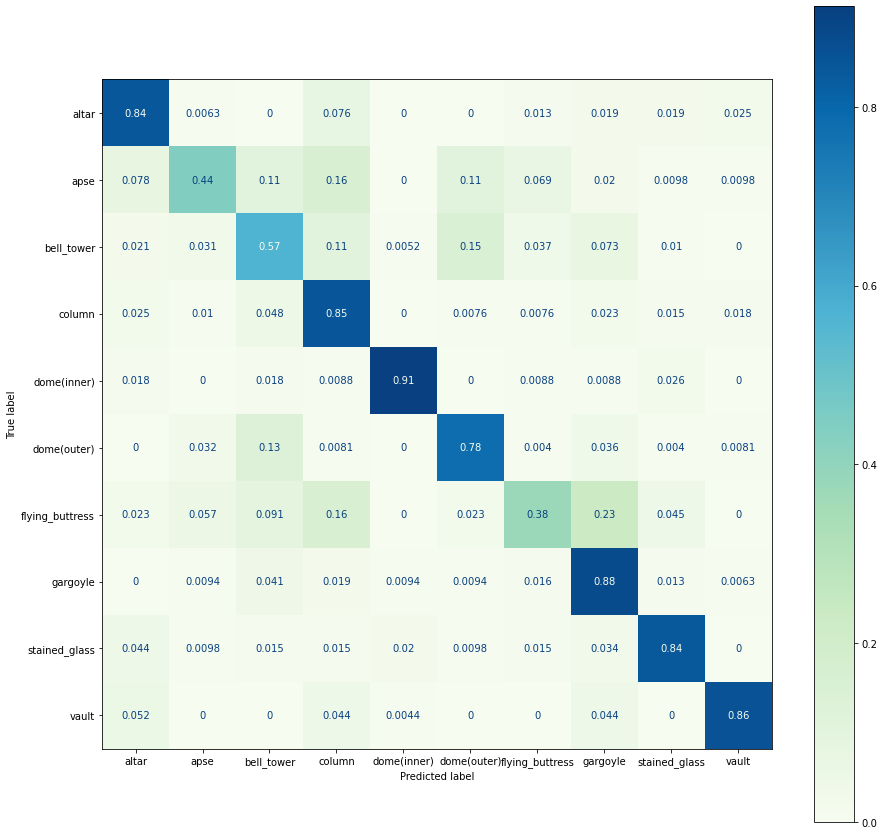

In [11]:
trainer.plot_confusion_matrix(x_test, y_test, etl.classes, normalize='true')

In [12]:
trainer.save('svm_classifier')

## Deep learning model
We are going to try to develop a CNN model to see if the predictions improve. For this, as before we are going to use some of the classes created to make training and plots easy.

At first we will not apply any transformation to the images, and in a later point in time we will try to find good parameters and augment the images (rotate, flip...) so we can artifically have more variance. 

We have implemented a CNN model with 3 convolutional layers, a dropout after the `MaxPooling2D` and two final dense layers. It's important to notice that the rescaling layer can be controled by a parameter, so we can activate or deactivate at Model instantiation. 

```python
InputLayer(input_shape=(pixels, pixels, 3))
if normalize:
    Rescaling(1./255)
Conv2D(16, 3, padding='same', activation='relu')
MaxPooling2D()
Dropout(rate = dropout)
Conv2D(32, 3, padding='same', activation='relu')
MaxPooling2D()
Dropout(rate = dropout)
Conv2D(64, 3, padding='same', activation='relu')
MaxPooling2D()
Dropout(rate = dropout)
Flatten()
Dense(128, activation='relu')
Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.0001))
```

In [13]:
etl = PrepareTrainingData()
y = etl.encode(y_labels)
print(x.shape)
etl.transform(x, y, batch_size=60, test_split=0.2, validation_split=0.2, extra_transformations=[], do_data_augmentation=False)


(10236, 128, 128, 3)


In [14]:
import tensorflow_addons as tfa
metrics = [
    'accuracy',
    tfa.metrics.F1Score(len(etl.classes)),
]

In [15]:
from arch_elements.model_train import CNNTrainer
# Initial dropout that you find in tutorials
trainer = CNNTrainer(pixels, dropout=0.2)
trainer.train(etl, epochs=30, metrics=metrics)

Epoch 1/30
109/109 [==============================] - 8s 30ms/step - loss: 2.2123 - accuracy: 0.2446 - f1_score: 0.1734 - val_loss: 1.6839 - val_accuracy: 0.4685 - val_f1_score: 0.3653
Epoch 2/30
109/109 [==============================] - 1s 13ms/step - loss: 1.5610 - accuracy: 0.5270 - f1_score: 0.4447 - val_loss: 1.5166 - val_accuracy: 0.5568 - val_f1_score: 0.4986
Epoch 3/30
109/109 [==============================] - 1s 13ms/step - loss: 1.3539 - accuracy: 0.6337 - f1_score: 0.5730 - val_loss: 1.4846 - val_accuracy: 0.5852 - val_f1_score: 0.5626
Epoch 4/30
109/109 [==============================] - 2s 14ms/step - loss: 1.2397 - accuracy: 0.6978 - f1_score: 0.6451 - val_loss: 1.3002 - val_accuracy: 0.6617 - val_f1_score: 0.5971
Epoch 5/30
109/109 [==============================] - 1s 13ms/step - loss: 1.1316 - accuracy: 0.7427 - f1_score: 0.7036 - val_loss: 1.2623 - val_accuracy: 0.6747 - val_f1_score: 0.6496
Epoch 6/30
109/109 [==============================] - 1s 14ms/step - loss: 

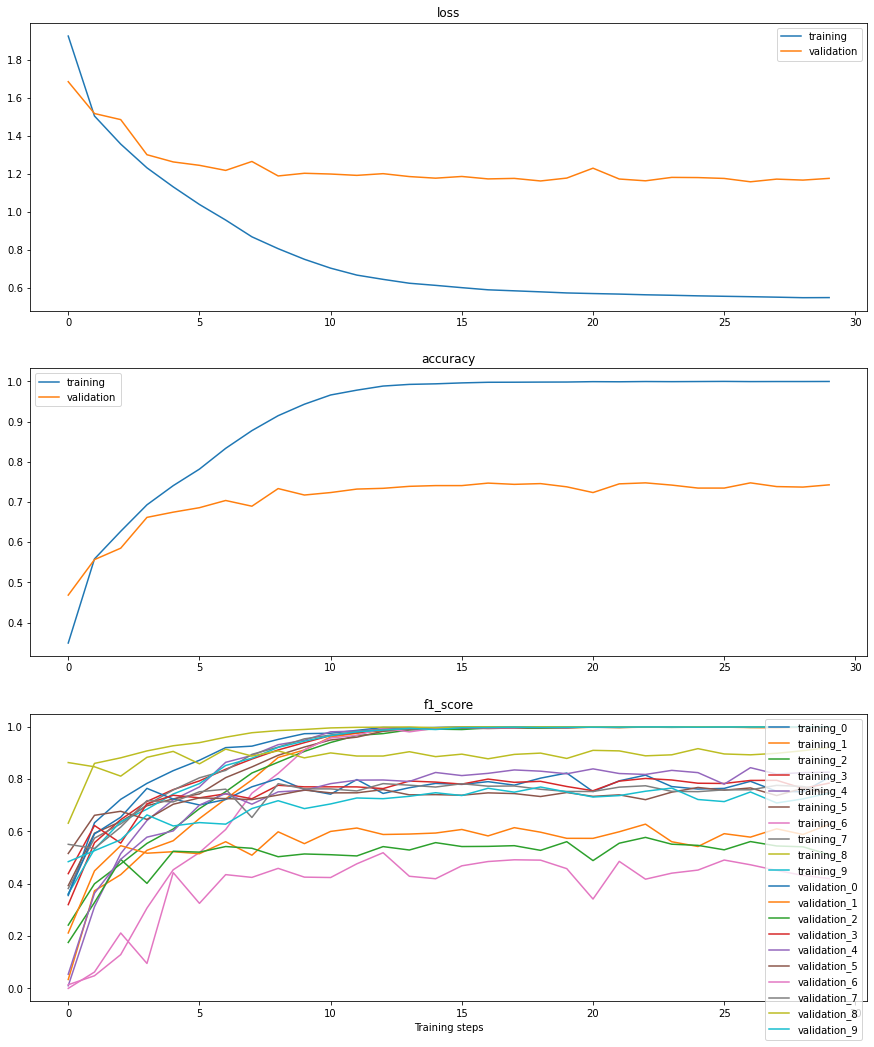

In [16]:
trainer.plot_all_metrics()

In [17]:
eval_metrics = {accuracy_score:{}, f1_score:{'average':'weighted'}}
x_test, y_test = etl.get_test_data()
trainer.evaluate_metrics(x_test, y_test, metrics=eval_metrics)

{'accuracy_score': 0.748046875, 'f1_score': 0.7542709276099303}

We see that we have obtained similar scores as with the SVM, but the model is overfitting and it reaches a plateau quicky. We can do better. Let's activate data augmentation, normalization and decrease the dropout. 

After performing a search over different values of dropout, `0.07` performs better than bigger ones with less overfitting. 

In [18]:
from arch_elements.model_train import CNNTrainer
# We are using the dropout and normalize because we have seen seen that it works best
etl.transform(x, y, batch_size=32, test_split=0.2, validation_split=0.2, do_data_augmentation=True)
trainer = CNNTrainer(pixels, dropout=0.07, normalize=True)
trainer.train(etl, epochs=40, metrics=metrics)

Epoch 1/40
204/204 [==============================] - 14s 65ms/step - loss: 1.9916 - accuracy: 0.3169 - f1_score: 0.4786 - val_loss: 1.6893 - val_accuracy: 0.4865 - val_f1_score: 0.4060
Epoch 2/40
204/204 [==============================] - 12s 59ms/step - loss: 1.6129 - accuracy: 0.4886 - f1_score: 0.4164 - val_loss: 1.4965 - val_accuracy: 0.5705 - val_f1_score: 0.4985
Epoch 3/40
204/204 [==============================] - 12s 59ms/step - loss: 1.5168 - accuracy: 0.5487 - f1_score: 0.4861 - val_loss: 1.5098 - val_accuracy: 0.5490 - val_f1_score: 0.5234
Epoch 4/40
204/204 [==============================] - 12s 59ms/step - loss: 1.4160 - accuracy: 0.5845 - f1_score: 0.5343 - val_loss: 1.2942 - val_accuracy: 0.6556 - val_f1_score: 0.5976
Epoch 5/40
204/204 [==============================] - 33s 163ms/step - loss: 1.3915 - accuracy: 0.5986 - f1_score: 0.5429 - val_loss: 1.2945 - val_accuracy: 0.6624 - val_f1_score: 0.6183
Epoch 6/40
204/204 [==============================] - 81s 396ms/step 

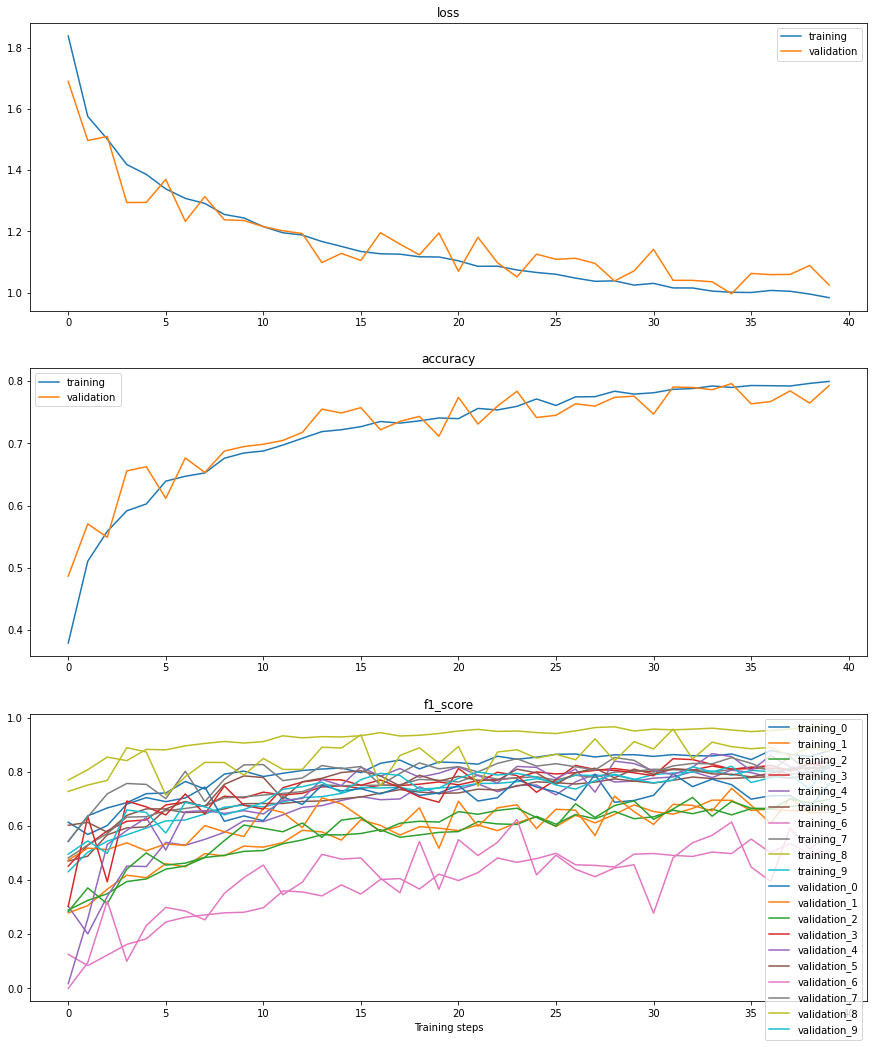

In [19]:
trainer.plot_all_metrics()

In [20]:
eval_metrics = {accuracy_score:{}, f1_score:{'average':'weighted'}}
x_test, y_test = etl.get_test_data()
trainer.evaluate_metrics(x_test, y_test, metrics=eval_metrics)

{'accuracy_score': 0.79150390625, 'f1_score': 0.790744338534114}

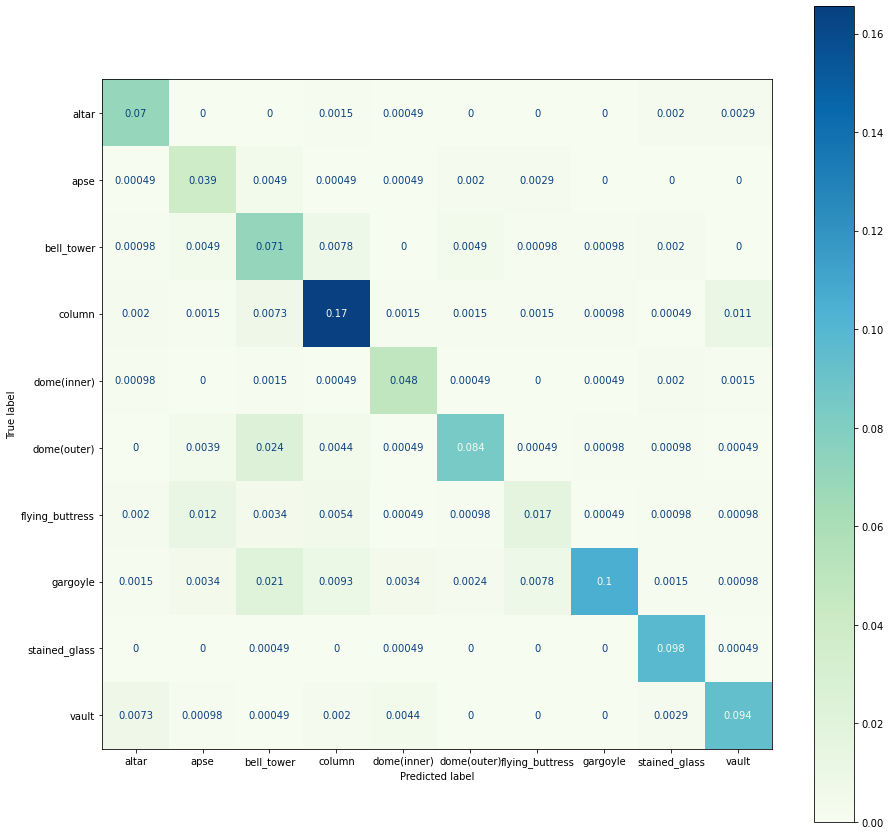

In [21]:
trainer.plot_confusion_matrix(x_test, y_test, etl.classes, normalize='all')

We have improved marginally the results. In the f1 score that we get for each label we can see that we have a disparity between values. Let's see if this could be correlated with the number of samples obtained. 

In [22]:
f1_per_label = trainer.model.evaluate(x_test, y_test)[-1]

64/64 [==============================] - 1s 13ms/step - loss: 1.0192 - accuracy: 0.7915 - f1_score: 0.7638


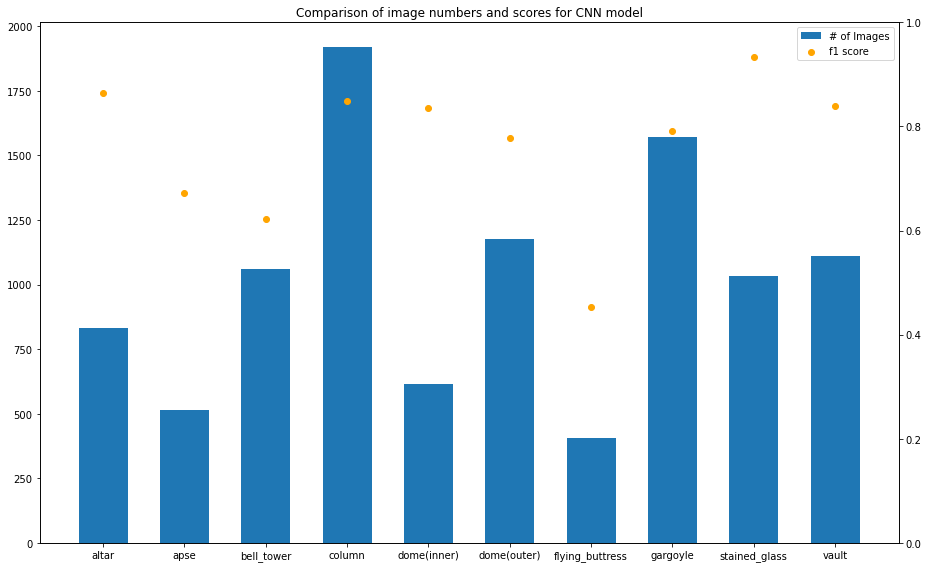

In [23]:
fig, ax = plt.subplots(figsize=(13, 8))
ax_score = ax.twinx()
# We use the frequency of images computing at the beginning
ax.set_title('Comparison of image numbers and scores for CNN model')
ax.bar(ls, freq, width=0.6, label='# of Images')
ax_score.scatter(etl.classes, f1_per_label, label='f1 score', color='orange')
ax_score.set_ylim(0,1)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_score.get_legend_handles_labels()
ax_score.legend(lines + lines2, labels + labels2)
fig.tight_layout()

This quick comparison shows that there not seems to be any relationship between the number of labeled images we have and the model prediction correctness for them. 

In [24]:
trainer.save('cnn')

INFO:tensorflow:Assets written to: .\cnn\assets


## Pre-trained model
The last option we will ivestigate is to use a pretrained model and then train it to predict our labels. For this, we have choosen Mobilenet V2  with depth multiplier of 1.00 for images of 128 pixels from tensorflow hub (https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/4)


We can observe that this speeds-up and improves the convergence time and classification correctness. 

In [3]:
import tensorflow_addons as tfa
metrics = [
    'accuracy',
    tfa.metrics.F1Score(len(etl.classes)),
]
etl.transform(x, y, batch_size=32, test_split=0.2, validation_split=0.2, do_data_augmentation=True)

In [4]:
from arch_elements.model_train import MobilenetTrainer
trainer = MobilenetTrainer(pixels)
trainer.train(etl, epochs=20, metrics=metrics)

Epoch 1/20
204/204 [==============================] - 32s 94ms/step - loss: 1.4715 - accuracy: 0.6672 - f1_score: 0.6264 - val_loss: 1.0585 - val_accuracy: 0.8609 - val_f1_score: 0.8048
Epoch 2/20
204/204 [==============================] - 13s 64ms/step - loss: 0.9153 - accuracy: 0.8808 - f1_score: 0.8651 - val_loss: 0.8429 - val_accuracy: 0.9142 - val_f1_score: 0.9051
Epoch 3/20
204/204 [==============================] - 13s 64ms/step - loss: 0.8268 - accuracy: 0.9116 - f1_score: 0.8967 - val_loss: 0.7626 - val_accuracy: 0.9338 - val_f1_score: 0.9260
Epoch 4/20
204/204 [==============================] - 13s 64ms/step - loss: 0.7797 - accuracy: 0.9308 - f1_score: 0.9104 - val_loss: 0.7397 - val_accuracy: 0.9467 - val_f1_score: 0.9409
Epoch 5/20
204/204 [==============================] - 14s 68ms/step - loss: 0.7589 - accuracy: 0.9403 - f1_score: 0.9315 - val_loss: 0.7708 - val_accuracy: 0.9387 - val_f1_score: 0.9339
Epoch 6/20
204/204 [==============================] - 13s 66ms/step - 

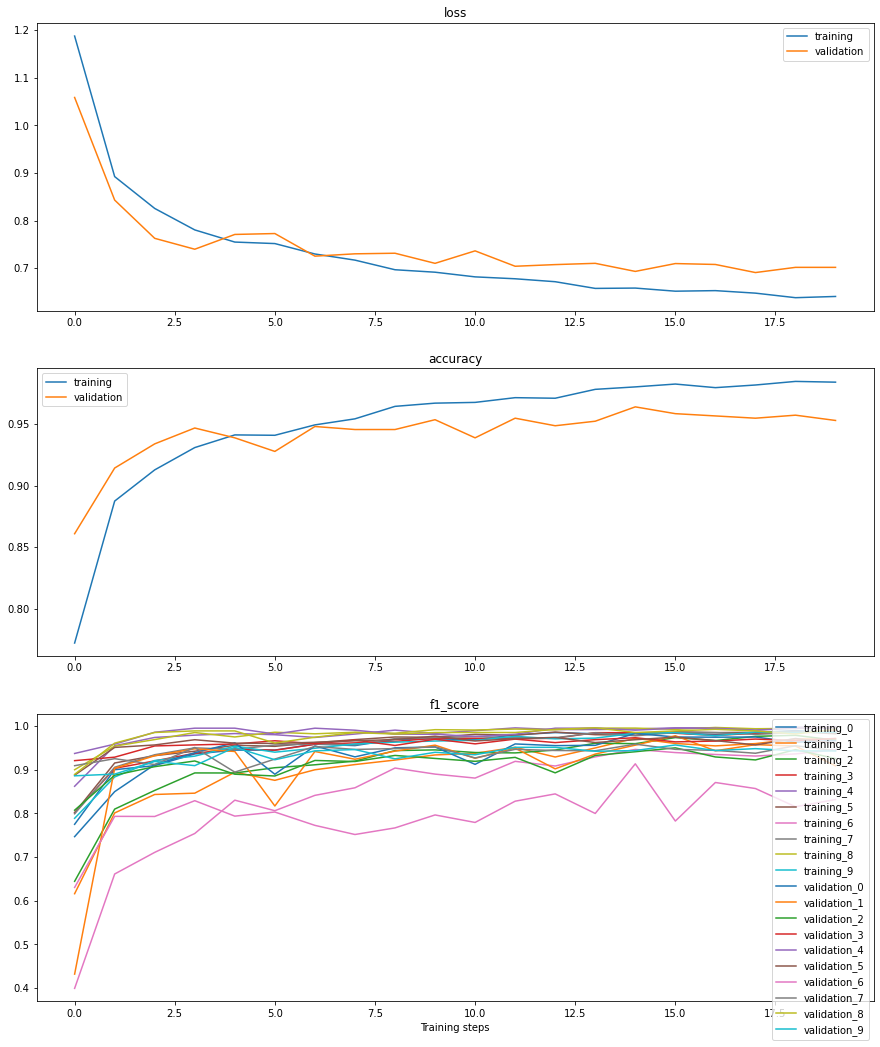

In [5]:
trainer.plot_all_metrics()

In [8]:
eval_metrics = {accuracy_score:{}, f1_score:{'average':'weighted'}}
x_test, y_test = etl.get_test_data()
trainer.evaluate_metrics(x_test, y_test, metrics=eval_metrics)

{'accuracy_score': 0.9580078125, 'f1_score': 0.9578677785138278}

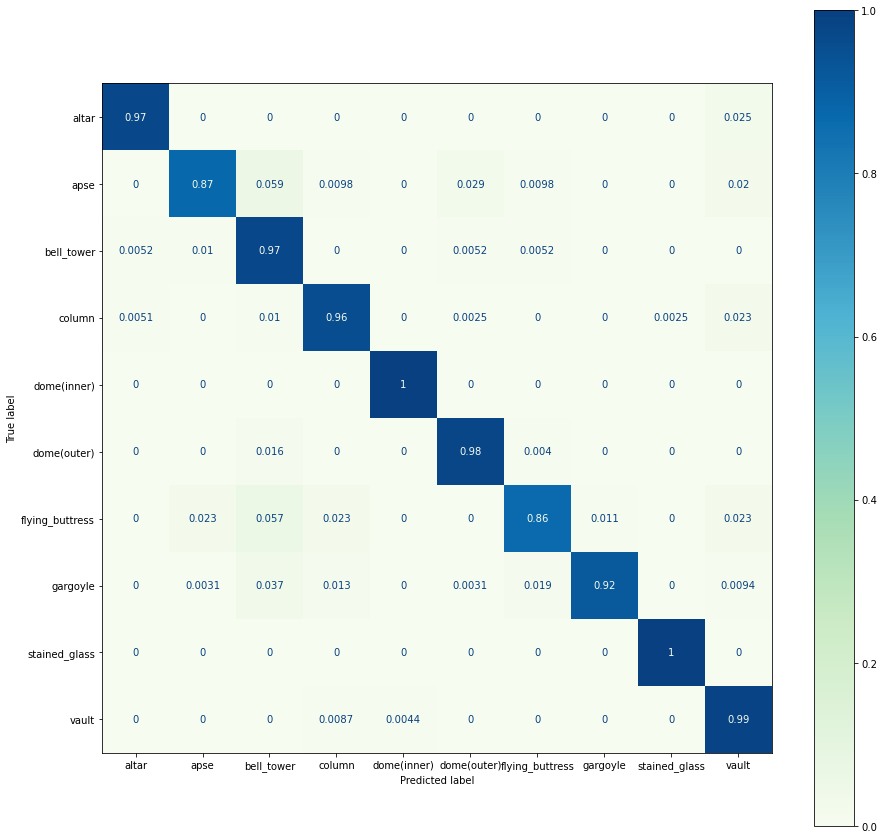

In [9]:
trainer.plot_confusion_matrix(x_test, y_test, etl.classes, normalize='true')

In [11]:
trainer.save('mobilenet')

INFO:tensorflow:Assets written to: .\mobilenet\assets
INFO:tensorflow:Assets written to: .\mobilenet\assets


# Summary

We have shown how a traditional SVM Classifier with some transformations can compete with a simple CNN network. However when we used a network optimized for those types of tasks with pre-trained weights over a big dataset, there is no point of comparison.  

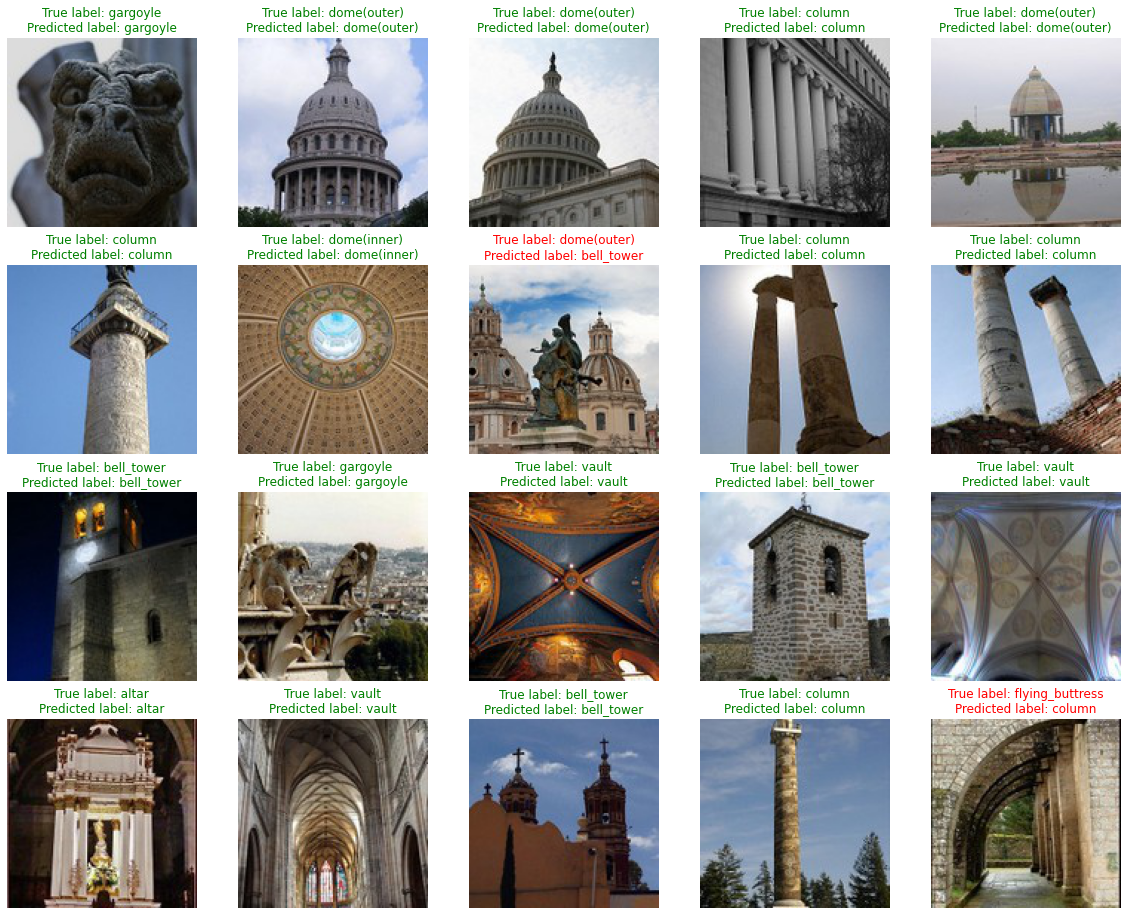

In [15]:
plot_samples(x_test, y_test, etl.encoder, 20, trainer.model)